In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

from scipy.interpolate import interp2d
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [75]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

We study the completeness of LSBG detection. 

The completeness is a product of 1) Johnny's detection completeness matrix; 2) completeness of vanilla scarlet (deblending step). The measurement error of the deblending step is taken care later.

Johnny sent me a gigantic folder containing all the catalogs of injected mock galaxies and detected ones. In this notebook, I try to recover a detection completeness map from those catalogs.

### Johnny's completeness map for detection

In [28]:
from scipy.interpolate import interp1d, interp2d
from scipy.stats import binned_statistic, binned_statistic_2d

In [41]:
GRECO = '/tigress/jgreco/project-code/hugs-s18a-ana/data/synth-results'

In [135]:
filelist = [[f'{GRECO}/synth-cat-{color}-0{i}.csv' for i in range(1, 5)] for color in ['reds', 'med', 'blues']]
filelist = [item for sublist in filelist for item in sublist]
params_cat = vstack([Table.read(file, format='csv') for file in filelist])
params_cat['rhalf_circularized'] = params_cat['r_e'] * np.sqrt(1 - params_cat['ell'])

filelist = [[f'{GRECO}/synth-match-{color}-0{i}.csv' for i in range(1, 5)] for color in ['reds', 'med', 'blues']]
filelist = [item for sublist in filelist for item in sublist]
detect_cat = vstack([Table.read(file, format='csv') for file in filelist])
detect_cat['rhalf_circularized'] = detect_cat['r_e'] * np.sqrt(1 - detect_cat['ell'])

In [136]:
bin_num = [15, 15]
_range = [[2, 15], [24, 29]]
_extent = [item for sublist in _range for item in sublist]

In [137]:
res_truth = binned_statistic_2d(
    params_cat['rhalf_circularized'].data,
    params_cat['mu_e_ave_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_truth_cuts = binned_statistic_2d(
    detect_cat['rhalf_circularized'].data,
    detect_cat['mu_e_ave_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

Text(0.5, 1.0, 'After cuts')

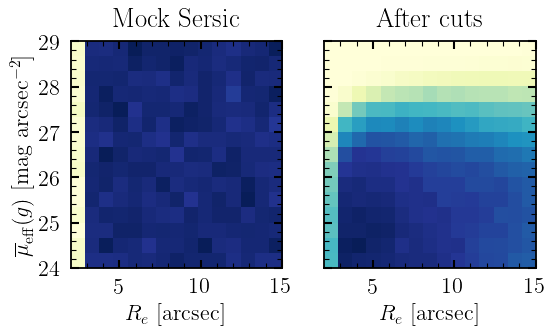

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True, sharex=False)

# In original size
plt.sca(axes[0])
plt.imshow(res_truth.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu')

plt.sca(axes[1])
plt.imshow(res_truth_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu')

for ax in axes.ravel().tolist():
    ax.set_xlabel(r'$R_e$ [arcsec]')
axes[0].set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

axes[0].set_title('Mock Sersic')
axes[1].set_title('After cuts')

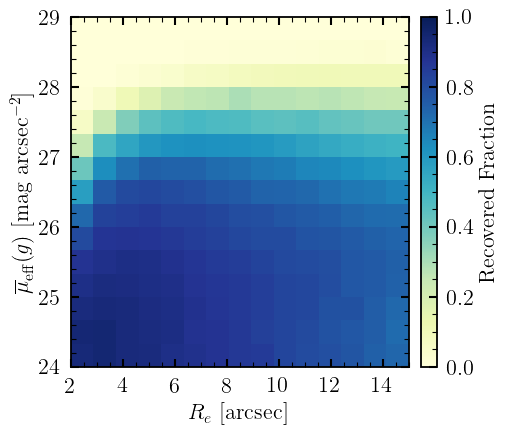

In [140]:
# fig, ax = plt.subplots(figsize=(3, 2.7))
fig, ax = plt.subplots(figsize=(4, 3.5))

detection_map = np.nan_to_num(res_truth_cuts.statistic.T / res_truth.statistic.T, 0, posinf=0)

im = plt.imshow(detection_map,
           extent=_extent,
#                 interpolation='gaussian',
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)

ax.set_xlim(_range[0])
ax.set_ylim(_range[1])
# ax.set_ylim(22, 29.2)
ax.set_xticks(np.arange(2, 15, 2))

ax.set_xlabel(r'$R_e$ [arcsec]')
ax.set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

## CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.04, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

In [141]:
np.save('./Catalog/Greco_completeness_S18A/S18A_completeness.npy', detection_map)

In [143]:
from sample_cuts import get_edge_cens
_x, _y = get_edge_cens([res_truth.x_edge, res_truth.y_edge])

In [144]:
np.save('./Catalog/Greco_completeness_S18A/S18A_completeness_re.npy', _x)
np.save('./Catalog/Greco_completeness_S18A/S18A_completeness_SB.npy', _y)

### Then go to `deblend_completeness.ipynb`!